# Notebook emulating plots from our WHAFT proposal

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

import gcsfs
from tqdm import tqdm
import fsspec

xr.set_options(display_style="html");
# xr.show_versions()

# Dask Startup

In [4]:
## A chunk of code to start dask cluster
from dask.distributed import Client, progress
from dask_gateway import Gateway
gateway = Gateway()

In [5]:
if gateway.list_clusters():
    cluster_name = gateway.list_clusters()[0].name
    cluster = gateway.connect(cluster_name)
    print(f"Connecting to pre-existing cluster with {len(cluster.scheduler_info['workers'])} workers.")
else:
    cluster = gateway.new_cluster() 
    cluster.adapt(minimum=2, maximum=12)
    print("Starting up and connecting to new cluster.")

cluster
# cluster.scheduler_info

Starting up and connecting to new cluster.


In [6]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.c7c4906b0dfe421fbfc61a40aee79406 Dashboard: /services/dask-gateway/clusters/prod.c7c4906b0dfe421fbfc61a40aee79406/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### setup runtime parameters

In [7]:
gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'domain_03'
filepattern = 'wrf-20161225*'


In [8]:
# pattern = 'gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-20161225*'
pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-20161225*


### list the netcdf files

In [9]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)

In [10]:
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} wrf files.")
print(NCs[0])

Total of 8 wrf files.
ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122500_f003-cf.nc


In [ ]:
# url = 'gs://' + NCs[0]
# with  fsspec.open(url, mode='rb')  as openfile:  
#     ds = xr.open_dataset(openfile, engine='h5netcdf', 
#                          chunks={'south_north': 200, 'west_east': 200, 'time': 1})  # , decode_coords=False
    
# for i in tqdm(range(1, len(NCs)-1)):  
#     url = 'gs://' + NCs[i]
#     with  fsspec.open(url, mode='rb')  as openfile:  
#         temp = xr.open_dataset(openfile, engine='h5netcdf', 
#                                chunks={'south_north': 200, 'west_east': 200, 'time': 1})  
#     ds = xr.concat([ds,temp],'time')

### Alternatively using `open_mfdatasets`

Build list of URLs to public data in the bucket

In [10]:
# url = 'https://storage.googleapis.com/ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc#mode=bytes'  
# ds = xr.open_dataset(url, engine='netcdf4', chunks=3000)
# ds

In [12]:
NCs_urls = ['https://storage.googleapis.com/' + x + '#mode=bytes' for x in NCs]
print(NCs_urls)

['https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122500_f003-cf.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122500_f006-cf.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122500_f009-cf.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122500_f012-cf.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122512_f003-cf.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122512_f006-cf.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122512_f009-cf.nc#mode=bytes', 'https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016122512_f012-cf.nc#mode=bytes']


In [13]:
# xr.open_mfdataset(NCs_urls, parallel=True)
# ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', chunks={'time': 1})
ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True,
                       combine = 'by_coords', chunks={'time': -1})

In [14]:
print(type(ds.T_sfc.data))
print(ds.T_sfc.chunks)

<class 'dask.array.core.Array'>
((1, 1, 1, 1, 1, 1, 1, 1), (825,), (537,))


In [15]:
ds.T_sfc


<xarray.DataArray 'T_sfc' (time: 8, south_north: 825, west_east: 537)>
dask.array<concatenate, shape=(8, 825, 537), dtype=float32, chunksize=(1, 825, 537), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-12-25T03:00:00 ... 2016-12-26
    lat      (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
    lon      (south_north, west_east) float32 dask.array<chunksize=(825, 537), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    long_name:      Temperature at the Surface
    standard_name:  surface_temperature
    units:          K

## Quick overview plot

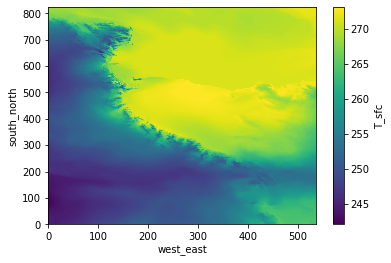

In [16]:
ds['T_sfc'].mean(dim='time').plot()

## Test write to zarr

In [29]:
outdir = os.path.join(gcsdir, ampsdir, amps_ver, domain, 'zarr-cf/')
# fs.glob(outdir)
fs.ls(outdir)

['ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-cf/test_20161225-cf.zarr']

In [23]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'test_20161225-cf.zarr', mode='ab',
                            token=token)
# ds.to_zarr(amps_mapper, mode='w');

['ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-cf/test_20161225-cf.zarr']

## Close your cluster, be a good denizen.

In [2]:
cluster.shutdown()

NameError: name 'cluster' is not defined